In [1]:
# importing necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomZoom, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras import Model, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
import os
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split


C:\Users\kpegg\AppData\Local\Temp\ipykernel_22444\3274493274.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


C:\Users\kpegg\AppData\Local\Temp\ipykernel_22444\3274493274.py:16: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
train = "../data/dog-breed-identification/train"
test = "../data/dog-breed-identification/test"
df=pd.read_csv("../data/dog-breed-identification/labels.csv")
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [27]:
labels = df["breed"].unique().tolist()
labels

['boston_bull',
 'dingo',
 'pekinese',
 'bluetick',
 'golden_retriever',
 'bedlington_terrier',
 'borzoi',
 'basenji',
 'scottish_deerhound',
 'shetland_sheepdog',
 'walker_hound',
 'maltese_dog',
 'norfolk_terrier',
 'african_hunting_dog',
 'wire-haired_fox_terrier',
 'redbone',
 'lakeland_terrier',
 'boxer',
 'doberman',
 'otterhound',
 'standard_schnauzer',
 'irish_water_spaniel',
 'black-and-tan_coonhound',
 'cairn',
 'affenpinscher',
 'labrador_retriever',
 'ibizan_hound',
 'english_setter',
 'weimaraner',
 'giant_schnauzer',
 'groenendael',
 'dhole',
 'toy_poodle',
 'border_terrier',
 'tibetan_terrier',
 'norwegian_elkhound',
 'shih-tzu',
 'irish_terrier',
 'kuvasz',
 'german_shepherd',
 'greater_swiss_mountain_dog',
 'basset',
 'australian_terrier',
 'schipperke',
 'rhodesian_ridgeback',
 'irish_setter',
 'appenzeller',
 'bloodhound',
 'samoyed',
 'miniature_schnauzer',
 'brittany_spaniel',
 'kelpie',
 'papillon',
 'border_collie',
 'entlebucher',
 'collie',
 'malamute',
 'welsh

In [14]:
# add '.jpg' to id for image_id
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")

# converting images to numpy array
image_size = 200  # Adjust to your desired image size

train_data = np.zeros((len(df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array with preprocessing
    img_array = np.array(img)/255
    
    # Convert to array and preprocess
    #img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    train_data[i] = img_array

In [15]:
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
label_data = encoder.fit_transform(df["breed"].values)

In [16]:
X = train_data
y = label_data

X_train_temp, X_test, y_train_temp, _ = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

# adding a data augmentation layer
data_aug = Sequential([                                    
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomContrast(0.2)                                  
], name='data_augmentation')

split_model = Sequential(
    data_aug
)

# Add Convolutional layers with dropout
split_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
split_model.add(MaxPooling2D((2, 2)))
split_model.add(Dropout(0.25))  # Add dropout after the first convolutional layer

split_model.add(Conv2D(64, (3, 3), activation='relu'))
split_model.add(MaxPooling2D((2, 2)))

split_model.add(Conv2D(128, (3, 3), activation='relu'))
split_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
split_model.add(Flatten())
split_model.add(Dense(256, activation='relu'))  # Increase the number of nodes in this dense layer
split_model.add(Dense(128, activation='relu'))
split_model.add(Dense(120, activation='softmax'))  # 120 output classes

# Compile the model
split_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use validation_split parameter in the fit function to split the training data into training and validation sets

split_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)



Epoch 1/50
109/109 [==============================] - 296s 3s/step - loss: 4.8483 - accuracy: 0.0089 - val_loss: 4.8151 - val_accuracy: 0.0115
Epoch 2/50
109/109 [==============================] - 271s 2s/step - loss: 4.7987 - accuracy: 0.0145 - val_loss: 4.7707 - val_accuracy: 0.0144
Epoch 3/50
109/109 [==============================] - 246s 2s/step - loss: 4.6866 - accuracy: 0.0199 - val_loss: 4.6317 - val_accuracy: 0.0173
Epoch 4/50
109/109 [==============================] - 240s 2s/step - loss: 4.6084 - accuracy: 0.0226 - val_loss: 4.5874 - val_accuracy: 0.0305
Epoch 5/50
109/109 [==============================] - 239s 2s/step - loss: 4.5678 - accuracy: 0.0227 - val_loss: 4.5586 - val_accuracy: 0.0253
Epoch 6/50
109/109 [==============================] - 237s 2s/step - loss: 4.5133 - accuracy: 0.0298 - val_loss: 4.4541 - val_accuracy: 0.0316
Epoch 7/50
109/109 [==============================] - 237s 2s/step - loss: 4.4281 - accuracy: 0.0388 - val_loss: 4.3707 - val_accuracy: 0.0449

image_size = 100

split_model.fit(X_train, y_train, validation_split=0.3, epochs=50, batch_size=64)
- loss: 3.8146, accuracy .1065; val_loss: 4.44, val_acc: .058

split_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)
- loss: 2.94, accuracy: .262, val_loss: 4.55, val_acc: .0903

image_size = 224

Pre-trained models: ResNet/Efficiency/VGG

Look at most common breeds
AKC classes: toy, sport, etc.

Adding a column & putting breeds into categories, instead of individual breeds to decrease classes

In [28]:
# Create a dictionary mapping each breed to its category
breed_to_category = {
'boston_bull': 'non-sporting',
 'dingo': 'wild',
 'pekinese': 'toy',
 'bluetick': 'hound',
 'golden_retriever': 'sporting',
 'bedlington_terrier': 'terrier',
 'borzoi': 'hound',
 'basenji': 'hound',
 'scottish_deerhound': 'hound',
 'shetland_sheepdog': 'herding',
 'walker_hound': 'hound',
 'maltese_dog': 'toy',
 'norfolk_terrier': 'terrier',
 'african_hunting_dog': 'wild',
 'wire-haired_fox_terrier': 'terrier',
 'redbone': 'hound',
 'lakeland_terrier': 'terrier',
 'boxer': 'working',
 'doberman': 'working',
 'otterhound': 'hound',
 'standard_schnauzer': 'working',
 'irish_water_spaniel': 'sporting',
 'black-and-tan_coonhound': 'hound',
 'cairn': 'terrier',
 'affenpinscher': 'toy',
 'labrador_retriever': 'sporting',
 'ibizan_hound': 'hound',
 'english_setter': 'sporting',
 'weimaraner': 'sporting',
 'giant_schnauzer': 'working',
 'groenendael': 'herding',
 'dhole': 'wild',
 'toy_poodle': 'toy',
 'border_terrier': 'terrier',
 'tibetan_terrier': 'non-sporting',
 'norwegian_elkhound': 'hound',
 'shih-tzu': 'toy',
 'irish_terrier': 'terrier',
 'kuvasz': 'working',
 'german_shepherd': 'herding',
 'greater_swiss_mountain_dog': 'working',
 'basset': 'hound',
 'australian_terrier': 'terrier',
 'schipperke': 'non-sporting',
 'rhodesian_ridgeback': 'hound',
 'irish_setter': 'sporting',
 'appenzeller': 'working',
 'bloodhound': 'hound',
 'samoyed': 'working',
 'miniature_schnauzer': 'terrier',
 'brittany_spaniel': 'sporting',
 'kelpie': 'herding',
 'papillon': 'toy',
 'border_collie': 'herding',
 'entlebucher': 'herding',
 'collie': 'herding',
 'malamute': 'working',
 'welsh_springer_spaniel': 'sporting',
 'chihuahua': 'toy',
 'saluki': 'hound',
 'pug': 'toy',
 'malinois': 'herding',
 'komondor': 'working',
 'airedale': 'terrier',
 'leonberg': 'working',
 'mexican_hairless': 'non-sporting',
 'bull_mastiff': 'working',
 'bernese_mountain_dog': 'working',
 'american_staffordshire_terrier': 'terrier',
 'lhasa': 'non-sporting',
 'cardigan': 'herding',
 'italian_greyhound': 'toy',
 'clumber': 'sporting',
 'scotch_terrier': 'terrier',
 'afghan_hound': 'hound',
 'old_english_sheepdog': 'herding',
 'saint_bernard': 'working',
 'miniature_pinscher': 'toy',
 'eskimo_dog': 'non-sporting',
 'irish_wolfhound': 'hound',
 'brabancon_griffon': 'toy',
 'toy_terrier': 'toy',
 'chow': 'non-sporting',
 'flat-coated_retriever': 'sporting',
 'norwich_terrier': 'terrier',
 'soft-coated_wheaten_terrier': 'terrier',
 'staffordshire_bullterrier': 'terrier',
 'english_foxhound': 'hound',
 'gordon_setter': 'sporting',
 'siberian_husky': 'working',
 'newfoundland': 'working',
 'briard': 'herding',
 'chesapeake_bay_retriever': 'sporting',
 'dandie_dinmont': 'terrier',
 'great_pyrenees': 'working',
 'beagle': 'hound',
 'vizsla': 'sporting',
 'west_highland_white_terrier': 'terrier',
 'kerry_blue_terrier': 'terrier',
 'whippet': 'hound',
 'sealyham_terrier': 'terrier',
 'standard_poodle': 'non-sporting',
 'keeshond': 'non-sporting',
 'japanese_spaniel': 'toy',
 'miniature_poodle': 'non-sporting',
 'pomeranian': 'toy',
 'curly-coated_retriever': 'sporting',
 'yorkshire_terrier': 'toy',
 'pembroke': 'herding',
 'great_dane': 'working',
 'blenheim_spaniel': 'toy',
 'silky_terrier': 'toy',
 'sussex_spaniel': 'sporting',
 'german_short-haired_pointer': 'sporting',
 'french_bulldog': 'non-sporting',
 'bouvier_des_flandres': 'herding',
 'tibetan_mastiff': 'working',
 'english_springer': 'sporting',
 'cocker_spaniel': 'sporting',
 'rottweiler': 'working'
    # Add more breeds and categories as needed
}

# Add a new column 'category' to the DataFrame based on the mapping
df['category'] = df['breed'].map(breed_to_category)

# Display the DataFrame to verify the changes
df

,id,breed,image_file,category
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg,non-sporting
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg,wild
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg,toy
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg,hound
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg,sporting
...,...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,ffd25009d635cfd16e793503ac5edef0.jpg,hound
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,ffd3f636f7f379c51ba3648a9ff8254f.jpg,terrier
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,ffe2ca6c940cddfee68fa3cc6c63213f.jpg,terrier
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,ffe5f6d8e2bff356e9482a80a6e29aac.jpg,toy


In [29]:
# checking on nulls

df['category'].isna().sum()

0

In [31]:
# checking on categories

categories = df["category"].unique().tolist()
categories

['non-sporting',
 'wild',
 'toy',
 'hound',
 'sporting',
 'terrier',
 'herding',
 'working']

In [34]:
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
cat_data = encoder.fit_transform(df["category"].values)

In [35]:
X = train_data
y = cat_data

X_train_temp, X_test, y_train_temp, _ = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

# adding a data augmentation layer
data_aug = Sequential([                                    
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomContrast(0.2)                                  
], name='data_augmentation')

cat_model = Sequential(
    data_aug
)

# Add Convolutional layers with dropout
cat_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
cat_model.add(MaxPooling2D((2, 2)))
cat_model.add(Dropout(0.25))  # Add dropout after the first convolutional layer

cat_model.add(Conv2D(64, (3, 3), activation='relu'))
cat_model.add(MaxPooling2D((2, 2)))

cat_model.add(Conv2D(128, (3, 3), activation='relu'))
cat_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
cat_model.add(Flatten())
cat_model.add(Dense(256, activation='relu'))  # Increase the number of nodes in this dense layer
cat_model.add(Dense(128, activation='relu'))
cat_model.add(Dense(120, activation='softmax'))  # 120 output classes

# Compile the model
cat_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use validation_split parameter in the fit function to split the training data into training and validation sets

cat_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)

Epoch 1/50
109/109 [==============================] - 170s 2s/step - loss: 2.3217 - accuracy: 0.1616 - val_loss: 2.1723 - val_accuracy: 0.1772
Epoch 2/50
109/109 [==============================] - 159s 1s/step - loss: 2.0306 - accuracy: 0.1829 - val_loss: 2.0750 - val_accuracy: 0.1824
Epoch 3/50
109/109 [==============================] - 158s 1s/step - loss: 2.0106 - accuracy: 0.1976 - val_loss: 2.0520 - val_accuracy: 0.1910
Epoch 4/50
109/109 [==============================] - 156s 1s/step - loss: 1.9967 - accuracy: 0.1996 - val_loss: 1.9900 - val_accuracy: 0.1939
Epoch 5/50
109/109 [==============================] - 157s 1s/step - loss: 1.9832 - accuracy: 0.2094 - val_loss: 2.0057 - val_accuracy: 0.1904
Epoch 6/50
109/109 [==============================] - 157s 1s/step - loss: 1.9717 - accuracy: 0.2155 - val_loss: 2.0062 - val_accuracy: 0.1887
Epoch 7/50
109/109 [==============================] - 156s 1s/step - loss: 1.9626 - accuracy: 0.2165 - val_loss: 1.9679 - val_accuracy: 0.2204

1/1 [==============================] - 0s 432ms/step


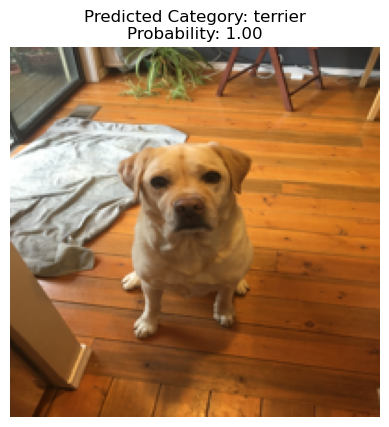

In [36]:
# Function to preprocess the image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) #/ 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path of the image to be predicted
image_path = r"C:\Users\kpegg\Documents\Flatiron\Projects\05_Nose_Knows\data\IMG_6753.jpg"

# Preprocess the image
preprocessed_img = preprocess_image(image_path, 200)

# Rotate the image
img_rotated = Image.open(image_path).rotate(270, expand=True)
img_rotated = img_rotated.resize((200, 200))  # Resize after rotation

# Preprocess the rotated image
preprocessed_rotated_img = np.array(img_rotated) #/ 255.0  # Normalize pixel values
preprocessed_rotated_img = np.expand_dims(preprocessed_rotated_img, axis=0)  # Add batch dimension

# Use the pre-trained model to predict the breed
predictions = cat_model.predict(preprocessed_rotated_img)
predicted_class_index = np.argmax(predictions)
predicted_category = df.iloc[predicted_class_index]["category"]
predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class

# Display the image
plt.imshow(img_rotated)
plt.title(f"Predicted Category: {predicted_category}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()

In [39]:
# Find the top 10 most common breeds
top_10_breeds = df['breed'].value_counts().nlargest(10).index.tolist()
top_10_breeds

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed']

In [38]:
# Filter the dataframe to include only the top 10 breeds
top_10_df = df[df['breed'].isin(top_10_breeds)]
top_10_df

,id,breed,image_file,category
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,003df8b8a8b05244b1d920bb6cf451f9.jpg,hound
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,0042188c895a2f14ef64a918ed9c7b64.jpg,hound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,00693b8bc2470375cc744a6391d397ec.jpg,toy
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,0162b3e0144fb1d1ab82fbff3ace9938.jpg,toy
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed,01b36cb1b80ab8c3a7d2b7128ad21bdc.jpg,working
...,...,...,...,...
10195,ff54d45962b3123bb67052e8e29a60e7,basenji,ff54d45962b3123bb67052e8e29a60e7.jpg,hound
10200,ff7d9c08091acc3b18b869951feeb013,maltese_dog,ff7d9c08091acc3b18b869951feeb013.jpg,toy
10204,ffa0055ec324829882186bae29491645,maltese_dog,ffa0055ec324829882186bae29491645.jpg,toy
10207,ffa4e1bf959425bad9228b04af40ac76,basenji,ffa4e1bf959425bad9228b04af40ac76.jpg,hound


In [41]:
top_10_df.breed.value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: count, dtype: int64

In [46]:
# Convert images to numpy array
top_10_train = np.zeros((len(top_10_df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(top_10_df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array2 = np.array(img)/255
    
    top_10_train[i] = img_array2